# 'Tables for Two' Exploratory Data Analysis
Last Updated: 10/31/2016

To get a feel for the data, let's try a few different mini-projects.
### The code in this notebook attempts to answer these questions:

1. How many restaurants total? How many restaurants / year?
2. Comparing restaurant reviews from different boroughs:
 1. How many reviews / borough?
 2. Sentiment analysis?
 3. Commonly used words?
3. Generate a random restaurant?
4. Has the distribution of restuarants moved over time?

In [204]:
#Let's import some useful packages
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import sqlite3 as lite
import pandas as pd
from textblob import TextBlob
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
%matplotlib inline  

# 1. Load and explore data using SQLite

To answer questions like:
1. How many restaurants in the database?
2. How many restaurants per year?

In [2]:
# load up the data that we have previously saved
con = lite.connect('T4T_070916.db')
with con:
    cur = con.cursor()

In [121]:
# 1. how many restaurants total?
with con:
    for row in cur.execute("SELECT COUNT(*) FROM Rest_inf"):
        print('%d restaurants total' % row)

805 restaurants total


In [4]:
# 2. how many restaurants per year?
with con:
    for row in cur.execute("SELECT substr(Date, 1, 4) AS year , COUNT(*) FROM Rest_inf GROUP BY 1"):
        print(row[0]+ '|' + '*'*row[1])

1954|********
1955|**********
1956|********
1957|******
1958|*
1959|**
1960|*
1992|*
1993|*
1998|*********
1999|**********************
2000|********************************
2001|********************************
2002|*******************************
2003|*****************************************
2004|********************************************
2005|***********************************************
2006|***********************************************
2007|*******************************************
2008|***********************************************
2009|***********************************************
2010|***********************************************
2011|***********************************************
2012|***********************************************
2013|************************************************
2014|************************************************
2015|***********************************************
2016|*****************************************


# 2. Sentiment analysis on our 'text' data.

3. Comparing restaurant reviews from different boroughs:
 1. How many reviews / borough?
 2. Sentiment analysis?
 3. Commonly used words?
 4. Uniquely used words?

Of the total 805 restaurants, the grand majority fall in Manhattan. 
How many are in other boroughs?

In [177]:
with con:
    for row in cur.execute('''
        SELECT COUNT(CASE WHEN Street LIKE '%Brooklyn%' THEN 1 ELSE NULL END)      AS brooklyn,
               COUNT(CASE WHEN text   LIKE '%Harlem%' THEN 1 ELSE NULL END)        AS harlem,
               COUNT(CASE WHEN Street LIKE '%Bronx%' THEN 1 ELSE NULL END)         AS bronx,
               COUNT(CASE WHEN Street LIKE '%Queens%' THEN 1 ELSE NULL END)        AS queens,
               COUNT(CASE WHEN Street LIKE '%Staten Island%' THEN 1 ELSE NULL END) AS staten_island
        FROM Rest_inf 
    '''):
        print('Brooklyn: %d \nHarlem: %d\nThe Bronx: %d\nQueens: %d\nStaten Island: %d' % (row[0], row[1], row[2], row[3], row[4]))

Brooklyn: 96 
Harlem: 17
The Bronx: 1
Queens: 8
Staten Island: 1


##  Comparing Restaurant Reviews from Brooklyn and Manhattan

Looks like we only have sufficient data to compare Brooklyn and Manhattan restaurants.

Let's grab a subset of restaurants from Manhattan that have a similarly matched time profile as those from Brooklyn.
First, we need to know how when Brooklyn restaurant reviews were published.

In [135]:
# first, how old are brooklyn reviews?
with con:
    for (index, row) in enumerate(cur.execute('''
        SELECT name, Street, Date 
        FROM Rest_inf 
        WHERE Street LIKE '%Brooklyn%'
        ORDER BY Date 
        LIMIT 10
    ''')):
        print(index, row)

0 ('Superfine', '126 Front St., Brooklyn ', '2003/03/24')
1 ('Quercy', '242 Court St., Brooklyn ', '2003/03/31')
2 ('Rug-B', '1310 Cortelyou Rd., Brooklyn ', '2003/09/15')
3 ('Sample', '152 Smith St., Brooklyn ', '2003/11/10')
4 ('D’Amico', '309 Court St., Brooklyn ', '2004/01/19')
5 ('Diner', '85 Broadway, at Berry St., Brooklyn ', '2004/02/16')
6 ('Franny’s', '295 Flatbush Ave., at Prospect Pl., Brooklyn ', '2004/10/18')
7 ('Café Regular', '318A 11th St., at Fifth Ave., Brooklyn ', '2004/11/01')
8 ('Tempo', '256 Fifth Ave., Brooklyn ', '2005/01/10')
9 ('Bouillabaisse', '126 Union St., Brooklyn ', '2005/03/21')


### The oldest Brooklyn restaurant review was published in 2003!

So, let's grab a subsample of our Manhattan restaurants that are from 2003 - 2016

Note: this query has bad performance on large tables. Luckily, ours is small

In [136]:
# grab a sample of manhattan restaurants
manhattan_sample = []
with con:
    for row in cur.execute('''
        SELECT name, Street, Latitude, Longitude, Date, Text 
        FROM Rest_inf
        WHERE Date >= '2003' 
        AND
        Street NOT IN ('%Brooklyn%', '%Bronx%', '%Queens%')
        ORDER BY RANDOM() 
        LIMIT 96
    '''):
        
        manhattan_sample.append(list(row))

In [137]:
# grab the brooklyn restaurants
brooklyn_sample = []
with con:
    for row in cur.execute('''
        SELECT name, Street, Latitude, Longitude, Date, Text 
        FROM Rest_inf
        WHERE Street LIKE '%Brooklyn%'
        ORDER BY Date 
    '''):       
        brooklyn_sample.append(list(row))

### Using TextBlob to analyze subjectivity and polarity of eacy review

(https://textblob.readthedocs.io/en/dev/index.html)

In [78]:
brooklyn_sentiment_pol = []
brooklyn_sentiment_sub = []
manhattan_sentiment_pol = []
manhattan_sentiment_sub = []

for i in brooklyn_sample:
    breview = TextBlob(i[5])
    brooklyn_sentiment_pol.append(breview.sentiment.polarity)
    brooklyn_sentiment_sub.append(breview.sentiment.subjectivity)

for j in manhattan_sample:
    mreview = TextBlob(j[5])
    manhattan_sentiment.append(mreview.sentiment.polarity)
    manhattan_sentiment.append(mreview.sentiment.subjectivity)

### Do Manhattan and Brooklyn reviews differ in subjectivity?

Subjectivity: [0, 1], where 0 = completely objective (facts), 1 = completely subjective (opinions)

Subjectivity Of Reviews


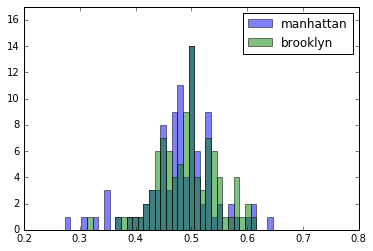

In [179]:
bins = np.linspace(0, 1, 100)

plt.hist(manhattan_sentiment_sub, bins, alpha=0.5, label='manhattan')
plt.hist(brooklyn_sentiment_sub, bins, alpha=0.5, label='brooklyn')
plt.legend(loc='upper right')
plt.axis([0.2, .8, 0, 17])
print("Subjectivity Of Reviews")
plt.show()

Manhattan and Brooklyn reviews appear (mostly) equally subjective

## Are Manhattan and Brooklyn reviews equally positive?

Polarity: [-1, 1], where -1 = very negative, 1 = very positive

Polarity of Reviews


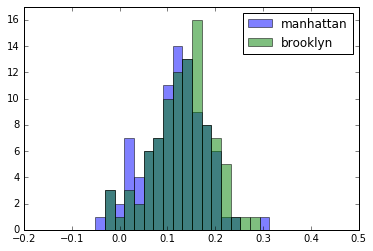

In [180]:
bins = np.linspace(-1, 1, 100)

plt.hist(manhattan_sentiment, bins, alpha=0.5, label='manhattan')
plt.hist(brooklyn_sentiment, bins, alpha=0.5, label='brooklyn')
plt.legend(loc='upper right')
plt.axis([-0.2, 0.5, 0, 17])
print("Polarity of Reviews")
plt.show()

## What textual differences appear between Manhattan and Brooklyn reviews?

1. First, import the NLTK stopwords list, and supplement with a few words of our own.
2. Glob all reviews from Manhattan or Brooklyn together
3. Count numbers of times each word appears 


In [138]:
# create a supplemented stopwords list, supplemented with menu-specific and html items:
add_ons = [',', '.', "''", '>', '<', 'data-wc=', 'word_count=', 'p', '/p', ')', 'no-indent', '(', '$', ':', '/em', 'em', '”', ';', 'dinner', '"', 'class=', 'restaurant', 'food', 'menu', 'open', 'entrées', 'span', '/span', '?', '!', 'dingbat','♦',"it’s", 'like', '1','2','3','4','5','6','7','8','9','0','145' ]
stopwords_T4T = stopwords.words('english')
for k in add_ons:
    stopwords_T4T.append(k)

In [62]:
# glob words together if they are not in the 'stopwords' list
manhattan_glob = []
for i in manhattan_sample:
    word_list = (nltk.word_tokenize(i[5]))
    for word in word_list:
        if word.lower().strip() not in stopwords_T4T:
            manhattan_glob.append(word.lower().strip())

brooklyn_glob = []
for j in brooklyn_sample:
    word_list = (nltk.word_tokenize(j[5]))
    for word in word_list:
        if word.lower().strip() not in stopwords_T4T:
            brooklyn_glob.append(word.lower().strip())

In [139]:
fd_m = FreqDist(manhattan_glob)
fd_b = FreqDist(brooklyn_glob)
#fd_m
#fd_b

FreqDist({'thick': 23,
          'room': 35,
          'balthazar': 1,
          'lower-key': 1,
          'scene': 7,
          'boys': 2,
          'easy': 13,
          'bendy': 1,
          'ketchup': 2,
          'unexpectedly': 1,
          'days': 9,
          'synonymy': 1,
          'exists': 2,
          'shelling': 1,
          'rejoinder': 1,
          'frozen': 4,
          'equipped': 1,
          'manhattanites': 2,
          'attempting': 2,
          'line-caught': 1,
          'stripped': 1,
          'spaghetti': 2,
          'exterior': 2,
          'delivering': 2,
          'chipped': 3,
          'dinner—don’t': 1,
          'beneath': 3,
          'kayf': 1,
          'hibernation': 1,
          'cater': 1,
          'experience': 11,
          'tomato-and-celery': 1,
          'found': 8,
          'entire': 5,
          'pleasing': 6,
          'iris': 1,
          'last': 17,
          'nearby': 7,
          'condiments': 4,
          'translation': 1,
      

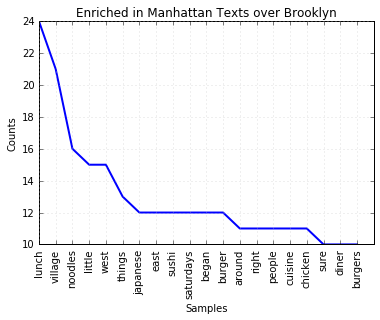

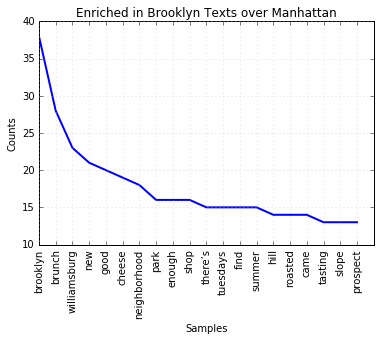

In [153]:
enriched_m = fd_m - fd_b
enriched_b = fd_b - fd_m

enriched_m.plot(20, cumulative = False, title = "Enriched in Manhattan Texts over Brooklyn")
enriched_b.plot(20, cumulative = False, title = "Enriched in Brooklyn Texts over Manhattan")

## What kind of unique words are found in Brooklyn and Manhattan reviews?

In [22]:
unique_m = []
for i in list(fd_m):
    if i not in list(fd_b):
        unique_m.append(i)
unique_b = []
for j in list(fd_b):
    if j not in list(fd_m):
        unique_b.append(j)

In [223]:
#unique_m
unique_b[0:15]

['habitat',
 'instructive',
 'eaters',
 'lower-key',
 'replicated',
 'bendy',
 'channel',
 'misheard',
 'custard-like',
 'synonymy',
 'shifts',
 'great-great-grandson',
 'amaranth-and-‘nduja',
 'beer-friendly',
 'manhattanites']

# 3. Given a keyword, pick a random restaurant
...to resolve weeknight dinner ambivalence.



In [156]:
def random_rest(keyword):
    with con:
        cur.execute('''
            SELECT Name, Street, Date, Latitude, Longitude, text 
            FROM Rest_inf 
            WHERE text LIKE ?
            ORDER BY RANDOM() 
            LIMIT 1''', ('%'+keyword +'%',))   
        return(cur.fetchall())

In [157]:
cuisine = ('')

In [165]:
random_rest(cuisine)

[('Megu',
  '62 Thomas St., at West Broadway ',
  '2004/12/20',
  40.7167176,
  -74.0075062,
  '<p data-wc="159" word_count="159">“Twenty-seven hours ago, a tuna was swimming in Oma Bay”—a waiter at this sleek new Japanese restaurant said the other night, as he wriggled his hands like a slippery fish through water—“and now he’s on your table at Megu.” Indeed, the sushi selection, centered on several cuts of <em>hon-maguro</em> tuna, is glisteningly fresh, if small. The greater portion of the <em>kaiseki</em>-style menu is lavish and poetically obfuscating, with a foreword that dedicates the diner’s palate to umami, the fifth taste. Delicately proportioned (and punitively priced) dishes, meant for sharing, are served with ceremonial flair, from the scaly root of wasabi grated on a slab of sharkskin to the Nakagawa River stone, where diners can lightly grill thin, tender, fat-streaked strips of Kobe beef. An enigmatic menu item boasts wild scallops and “mystery twin”—a small bite of turn

# 4. Where have restaurants moved over time?

Collect the 20 oldest restuarants (that have dates), and the 20 newest restaurants.
Export their locations for mapping!

In [235]:
oldest = []
newest = []
gmaps_old = []
gmaps_new = []
# get the 20 oldest restauarants
with con:
        for row in cur.execute('''
        SELECT Name, Latitude, Longitude, Id, Article
        FROM Rest_inf
        WHERE Street IS NOT 'null'
        ORDER BY Date
        LIMIT 20
    '''):
            oldest.append(row)

# get the 20 newest restaurants
with con:
        for row in cur.execute('''
        SELECT Name, Latitude, Longitude, Id, Article
        FROM Rest_inf
        WHERE Street IS NOT 'null'
        ORDER BY Date DESC
        LIMIT 20
    '''):
            newest.append(row)

for entry in oldest:
    try:
        lat = float(entry[1])
        lng = float(entry[2])
    except:
        lat = "null"       # a fair number of empty locations :(
        lng = "null"
    link = '<a href="' + entry[4] + '">' + entry[0] + '</a>'
    item = [link, lat, lng, int(entry[3])]
    gmaps_old.append(item)
    
gmaps_list = open('gmaps_list_oldest.txt', 'w')
gmaps_list.write(str(gmaps_old))
gmaps_list.close()


for entry in newest:
    try:
        lat = float(entry[1])
        lng = float(entry[2])
    except:
        lat = "null"       # a fair number of empty locations :(
        lng = "null"
    link = '<a href="' + entry[4] + '">' + entry[0] + '</a>'
    item = [link, lat, lng, int(entry[3])]
    gmaps_new.append(item)
    
gmaps_list = open('gmaps_list_newest.txt', 'w')
gmaps_list.write(str(gmaps_new))
gmaps_list.close()
